## Imports and load data

In [2]:
# Vectors, matrices, data manipulation, tables and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Statistics, econometrics

from tqdm import tqdm
# Show plots inline
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


In [4]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

###### Let's extract some features from 1D time series:
1. Lags of the time series
2. Window statistics:
    * Max/min value of series in a window
    * Average/median value of series in a window
    * Window variance
3. Date / time features:
    * Timestamps as pandas.to_datetime() or pandas.Timestamp
    * Special events (holidays, weekends, etc) as boolean
4. Target encoding
5. Other model forecasts
    

## 1. Lags

Shifting the time series $n$ steps back, we receive a feature column with the current value aligned with its value at time $t - n$. If we train model on that feature, we'll be able to forecast $n$ steps ahead from the currently observed state. But, if something fundamentally changes the series during that unobserved period, the model will not catch these changes. Therefore forecasting horizon should be as small as possible.

In [8]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ['y']

Add the lag of the variable from 6 steps down to 25 to generate a dataset

In [9]:
for i in range(6,25):
    data[f'lag_{(i)}'] = data.y.shift(i)

In [10]:
data.sample(6)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-20 21:00:00,101360,141590.0,141525.0,140990.0,138555.0,140850.0,121250.0,108265.0,97635.0,101440.0,104290.0,116335.0,123880.0,100010.0,85785.0,78110.0,79980.0,79270.0,92855.0,105585.0
2017-09-15 21:00:00,112945,147735.0,148020.0,146275.0,152470.0,140435.0,126640.0,108665.0,104185.0,98860.0,110940.0,115190.0,118430.0,88795.0,82640.0,75130.0,76315.0,82765.0,92175.0,103815.0
2017-09-17 12:00:00,166335,141405.0,129470.0,112570.0,98290.0,90575.0,89345.0,89060.0,93610.0,96700.0,117925.0,125245.0,146875.0,152525.0,147435.0,150645.0,151195.0,153735.0,152500.0,157375.0
2017-09-15 02:00:00,82640,129130.0,150520.0,149440.0,150570.0,149830.0,148810.0,148040.0,149150.0,148970.0,144325.0,130540.0,115840.0,102240.0,102475.0,109225.0,118030.0,125135.0,102080.0,85105.0
2017-09-17 05:00:00,129470,93610.0,96700.0,117925.0,125245.0,146875.0,152525.0,147435.0,150645.0,151195.0,153735.0,152500.0,157375.0,142480.0,131240.0,133190.0,143250.0,144440.0,141385.0,128950.0
2017-09-21 12:00:00,146630,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0,140610.0,141590.0,141525.0,140990.0,138555.0


Set five folds for time-series cross validation and define a function to split data

In [11]:
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
def timeseries_split_train_test(X, y, test_size:float):
    """
    Description : Perform train / test split with respect to time-series order and structure.
    
    Arguments : 
    ----------
        X : pandas.Series or pandas.DataFrame
            Set of features to be splitted to train and test data
        y : list, tuple or any other iterable
            Set of labels to be splitted to train and test labels
        test_size : float
            size of the test data in range [0,1], where 0 is 0% and 1 is for 100% of data
            
    Return : tuple
    --------
        4-D vector of training and test data
    """
    # Get the index, where test data starts
    test_index = int(len(X)*(1-test_size))
    # Locate training data
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    # Locate 
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Drop the initial column and use 30% of data for testing

In [13]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1) 

In [14]:
X_train, X_test, y_train, y_test = timeseries_split_train_test(X, y, test_size=0.3)


###### Train the linear regression for these data

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

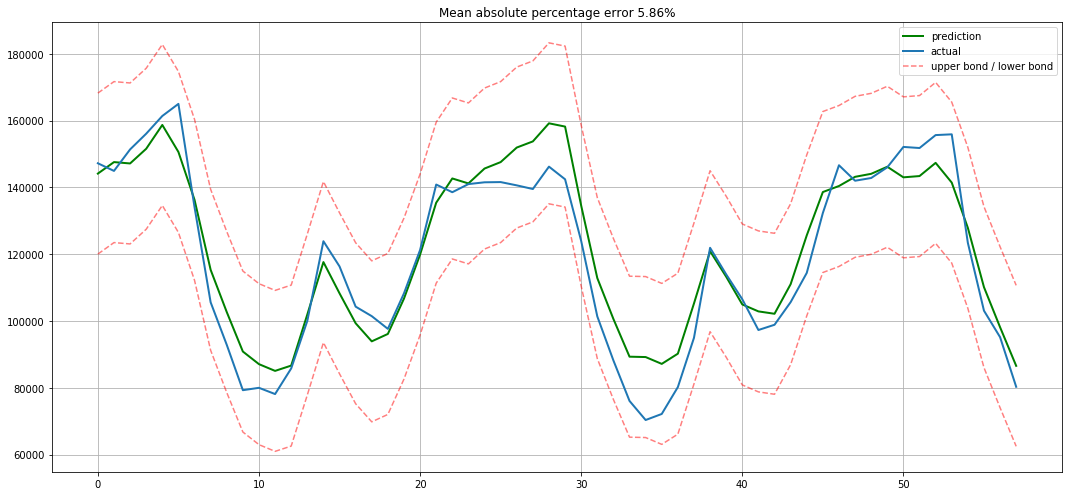

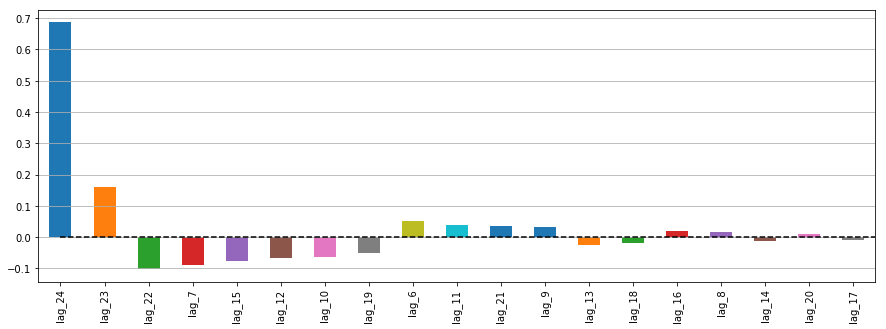

In [17]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

5,86% of MAPE is ok, especially, taking into account, that we've spent so much time to preprocess data for SARIMA and so little time to retrieve lags for the linear regression. But we can do more! 

Add hour, day of week, boolean `is_weekend`


In [18]:
# Convert dataset to datetime type
data.index = pd.to_datetime(data.index)
# Get hour, weekday and is_weekend
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
# Watch some data
data.sample(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-19 01:00:00,74670,153415.0,161520.0,150410.0,145335.0,145360.0,142220.0,141730.0,140120.0,135755.0,...,97655.0,99440.0,111325.0,123780.0,99790.0,88045.0,78350.0,1,1,0
2017-09-17 00:00:00,89060,152525.0,147435.0,150645.0,151195.0,153735.0,152500.0,157375.0,142480.0,131240.0,...,141385.0,128950.0,115940.0,104465.0,92350.0,88845.0,87835.0,0,6,1
2017-09-18 04:00:00,123780,97345.0,112955.0,142710.0,169900.0,168345.0,160020.0,159055.0,157305.0,163140.0,...,147550.0,141170.0,152580.0,152560.0,141405.0,129470.0,112570.0,4,0,0
2017-09-16 12:00:00,157375,141385.0,128950.0,115940.0,104465.0,92350.0,88845.0,87835.0,87615.0,100200.0,...,159725.0,149285.0,145750.0,147735.0,148020.0,146275.0,152470.0,12,5,1
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-19 23:00:00,79270,156080.0,151370.0,144935.0,147225.0,139165.0,146455.0,135990.0,119750.0,104185.0,...,113115.0,119345.0,97950.0,81990.0,74670.0,78335.0,79515.0,23,1,0
2017-09-17 10:00:00,147550,112570.0,98290.0,90575.0,89345.0,89060.0,93610.0,96700.0,117925.0,125245.0,...,150645.0,151195.0,153735.0,152500.0,157375.0,142480.0,131240.0,10,6,1


Visualize the resulting features

[]

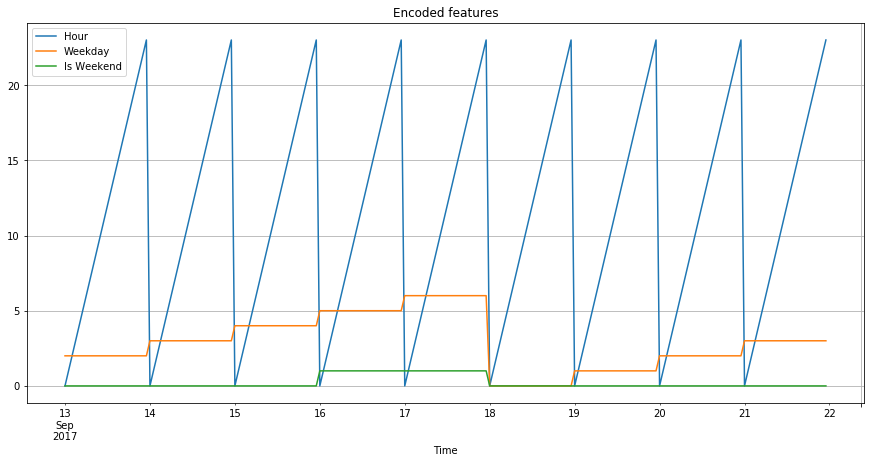

In [19]:
plt.figure(figsize=(15, 7))
# Add title
plt.title("Encoded features")
# Plot with pandas
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
# Add grid and legend with pyplot
plt.grid(True)
plt.legend(["Hour", "Weekday", "Is Weekend"])

plt.plot()

Variables are in different scales (days, hours, boolean). That's not OK.

In [20]:
scaler = StandardScaler()

/home/yurii/Tools/ts/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/yurii/Tools/ts/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/yurii/Tools/ts/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


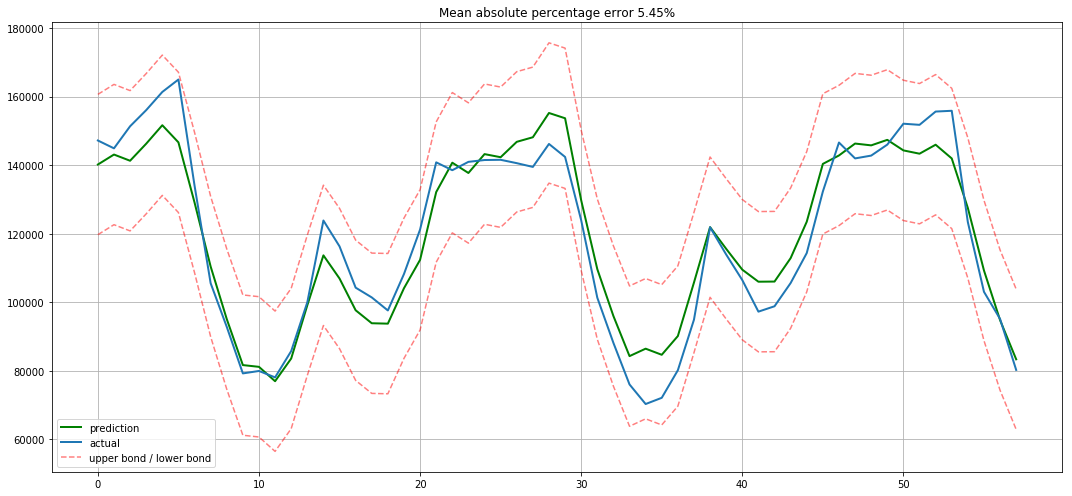

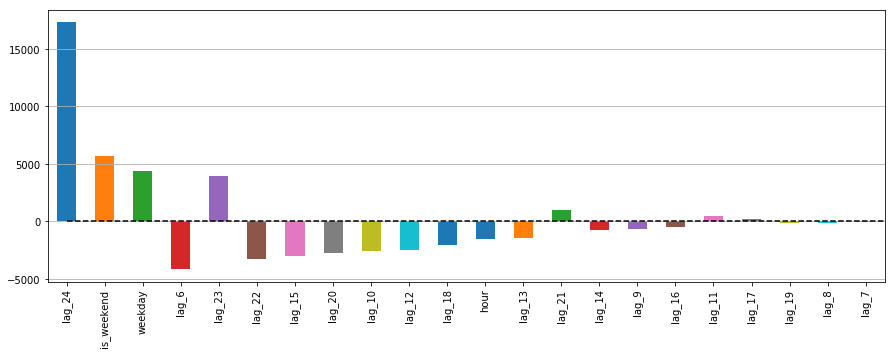

In [21]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_split_train_test(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

### Target encoding

One more option for encoding categorical variables is to encode it by mean value. It can be useful, when making too many one-hot variables is unwanted or can lead to the loss of information. Mean value should be encoded over the training set **only** (or current cross-validation fold **only**) to leave model be unaware of the future.

In [22]:
def code_mean(data, cat_feature, real_feature):
    """
        Description:
        
        Arguments:
        ----------
            data : 
            cat_feature : 
            real_feature : 
        Return: dict
        -------
            Dictionary with pairs unique_categories : values that are means over the real feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Averages by hour

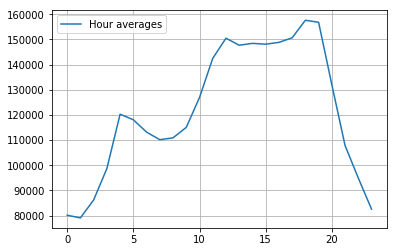

In [25]:
avg_hour = code_mean(data, 'hour', 'y')
pd.DataFrame.from_dict(avg_hour, orient='index')[0].plot()
plt.grid()
plt.legend(['Hour averages'])
plt.show()

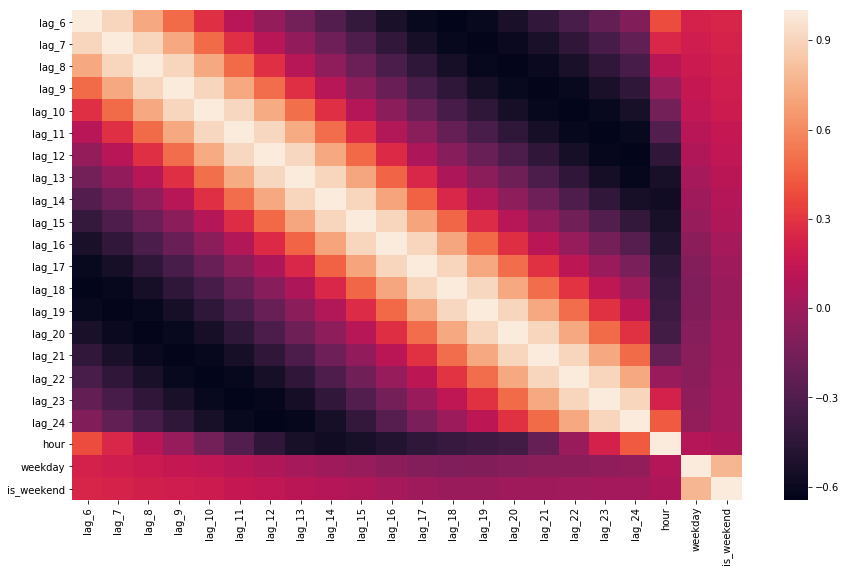

In [30]:
plt.figure(figsize=(15,9))
sn.heatmap(X_train.corr());

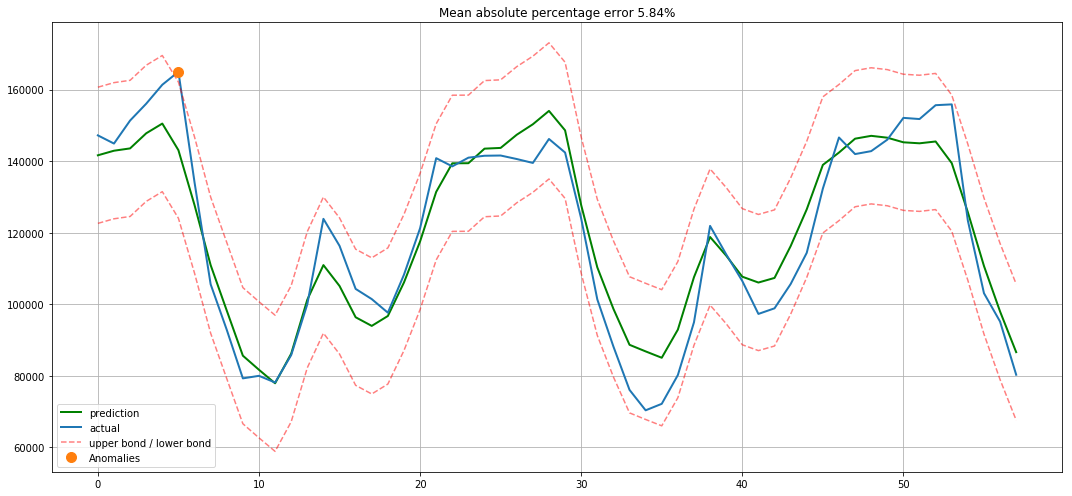

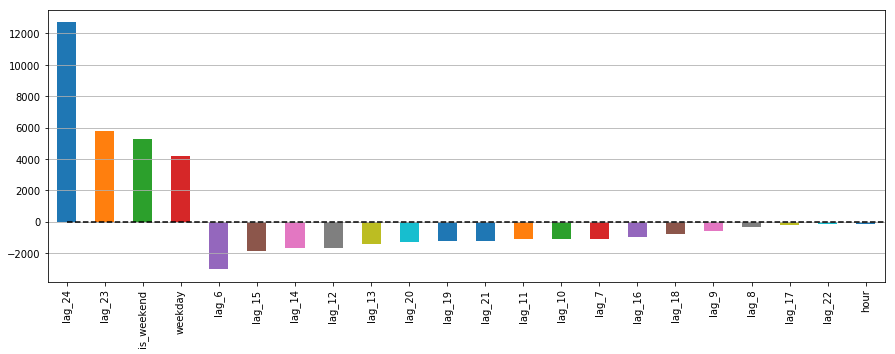

In [31]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

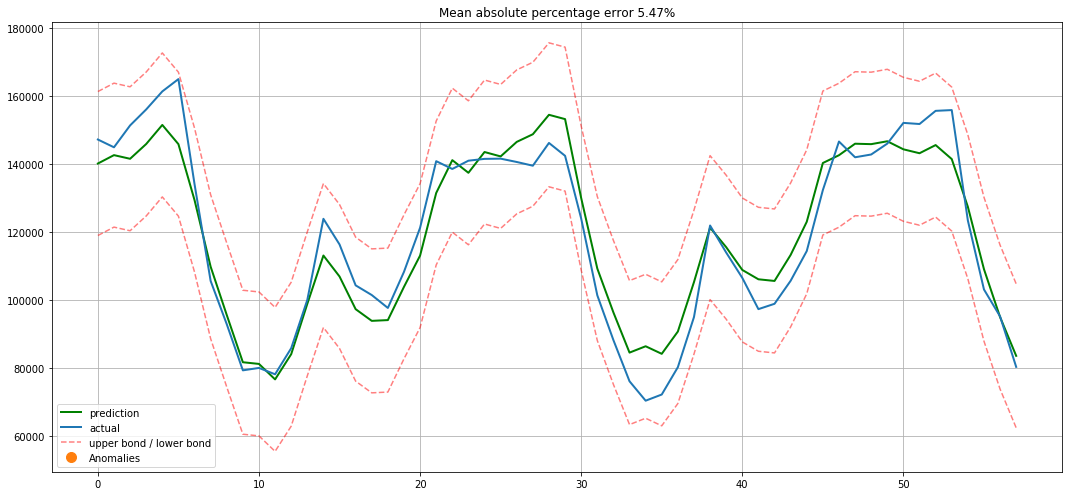

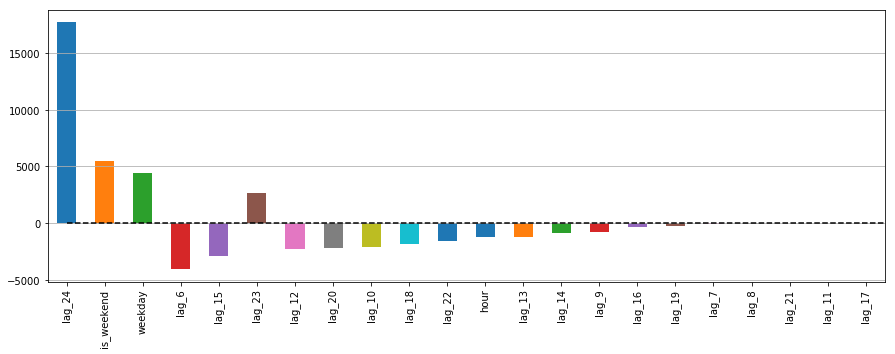

In [32]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [34]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

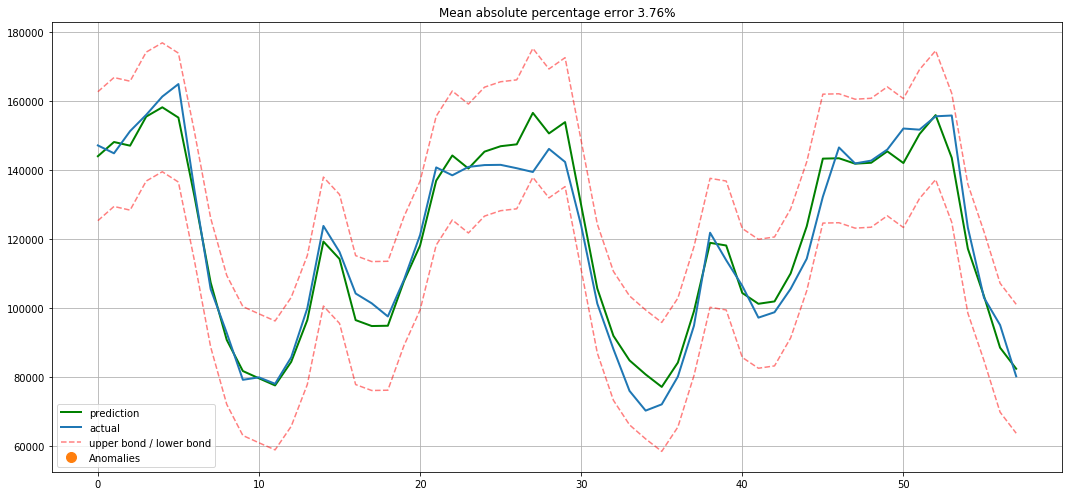

In [35]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)